In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msgn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import *

In [2]:
df = pd.read_pickle('df_v1-2021-10-12.pickle')

In [3]:
df.isna().sum()

order_date             0
user_id                0
is_elite_user          0
supplier_id            0
order_line_item_id     0
                      ..
cum_cat_counts_x       0
cum_cat_counts_y       0
past_total_paid        0
past_avg_paid          0
shifted_coupon_rate    0
Length: 67, dtype: int64

In [4]:
df.head(5)

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_variant_id,original_price,discounted_price,ship_cost,...,shifted_cum_mean_x,cum_mean_y,shifted_cum_mean_y,cum_prod_counts_x,cum_prod_counts_y,cum_cat_counts_x,cum_cat_counts_y,past_total_paid,past_avg_paid,shifted_coupon_rate
0,2021-05-19 01:27:28.768000+00:00,2141,0,216503,955598029,625610651,133066437,104.900002,69.900002,11.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2021-05-19 01:27:28.768000+00:00,2141,0,1188,955598030,625610651,77047570,79.989998,79.989998,8.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,2021-06-02 00:51:35.862000+00:00,2141,0,200788,988146564,643936439,153411316,110.300003,55.150002,8.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.100006,170.100006,0.0
3,2021-06-02 00:51:35.862000+00:00,2141,0,107296,988146563,643936439,172744639,59.900002,49.900002,8.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.100006,170.100006,0.0
4,2021-06-09 23:31:37.963000+00:00,2141,0,968,1007223734,654756664,162306389,119.989998,48.000000,9.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.910004,146.455002,0.0


In [24]:
label = ['is_returned']

categorical_str = [
'is_saved_card_trx',
'gender',
'zodiac'
] 

categorical_int = [
'gender_id',
'category_id',
'color_id',
'order_weekday',
'order_week',
'brand_id',
'order_day',
'hour_interval',
]

numerical = [
'n_unq_variants',
'original_price',
'discounted_price',
'ship_cost',
'coupon_discount',
'age',
'diff_order_memdate',
'total_claim',
'promotion_award_value',
'discount_ratio',
'paid_amount',
'n_unique_prods_in_basket',
'n_unique_cats_in_basket',
'cart_amount_mean',
'past_avg_paid',
'past_total_paid',
]

numerical2 = [
'returnRate',
'returnRate_def',
'unresolvedclaim_percentage',
'unresolved_percentage',
'shifted_return_rate',
'item_return_rate_user',
'general_prod_return_rate',
'shifted_coupon_rate',
]
passthrough = [
'is_elite_user',
'is_wallet_trx',
'is_bday_close']

drops = [
'color_name',
'supplier_color_name',
'attribute_value',
'attributet_name',
'gender_name',
'category_name',
'brand_name',
'product_name',
'coupon_id',
'promotion_name',
'order_date',
'birth_date',
'membership_date', 
'order_line_item_id',
'order_parent_id',
'product_content_id',
'product_id',
'product_variant_id',
'supplier_id',
'user_id']

In [19]:
df.drop(['cum_cat_counts_x', 'cum_mean_x', 'cum_mean_y', 'cum_prod_counts_x', 'shifted_cum_mean_x'], axis=1, inplace=True)

In [22]:
set(df.columns).difference(set(categorical_str+categorical_int+numerical+numerical2+passthrough+label+drops))

{'cum_cat_counts_y', 'cum_prod_counts_y', 'shifted_cum_mean_y'}

In [25]:
set(categorical_str+categorical_int+numerical+numerical2+passthrough+label+drops).difference(set(df.columns))

set()

In [26]:
null_df = df[df['is_returned'].isna()]
notna_df = df[df['is_returned'].notna()]

In [27]:
del df

In [28]:
import gc
gc.collect()

180

In [29]:
print(null_df['is_returned'].isna().sum()), print(notna_df['is_returned'].isna().sum())

421016
0


(None, None)

In [30]:
null_df.isna().sum()

order_date             0
user_id                0
is_elite_user          0
supplier_id            0
order_line_item_id     0
                      ..
cum_prod_counts_y      0
cum_cat_counts_y       0
past_total_paid        0
past_avg_paid          0
shifted_coupon_rate    0
Length: 62, dtype: int64

In [31]:
len(null_df['product_content_id'].unique())

119418

In [32]:
null_df.drop_duplicates(subset=['order_parent_id', 'product_content_id'], inplace=True)

In [33]:
null_df.shape

(405282, 62)

In [34]:
merged_df = notna_df[categorical_str+categorical_int+numerical+numerical2+passthrough+label]

matrix = merged_df.corr().abs()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
plt.figure(figsize=(16, 12))
sns.heatmap(matrix[matrix>0.5], mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap='crest')

plt.show();

In [35]:
def print_metrics(y_pred, y_test, model):
    print("Model results: ", type(model).__name__)
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    cm = confusion_matrix(y_test,y_pred, labels= model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= model.classes_)
    disp.plot()

In [36]:
def create_pipeline_rf():
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    numeric_transformer2 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))])
    
    categorical_str_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    
    categorical_int_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-99)),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    

    preprocessor = ColumnTransformer(
                                    transformers=[
                                                  ('num1', numeric_transformer, numerical),
                                                  ('num2', numeric_transformer2, numerical2),
                                                  ('cat_str1', categorical_str_transformer, categorical_str),
                                                  ('cat_int1', categorical_int_transformer, categorical_int),
                                                  ], 
                                    remainder='passthrough')

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('f_selector', SelectKBest(f_classif, k='all')),
                          ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0))])
    
    return pipeline

veriyi alırken

1. random
2. time based

In [37]:
pos_df = merged_df[merged_df['is_returned']==1].sample(200000)
neg_df = merged_df[merged_df['is_returned']==0].sample(200000)

model_df = pd.concat([pos_df, neg_df], axis=0)
model_df.sample(frac=1)

,is_saved_card_trx,gender,zodiac,gender_id,category_id,color_id,order_weekday,order_week,brand_id,order_day,...,unresolvedclaim_percentage,unresolved_percentage,shifted_return_rate,item_return_rate_user,general_prod_return_rate,shifted_coupon_rate,is_elite_user,is_wallet_trx,is_bday_close,is_returned
8614174,False,Bayan,none,4295.0,1182,7001.0,3,23,40,10,...,0.000000,0.000000,1.000000,0.333333,0.0,0.000000,0,1,0,1.0
4605637,False,Bayan,no-sign,4295.0,530,7001.0,2,26,4869,30,...,0.081633,0.003040,0.400000,0.300000,0.0,0.000000,0,0,0,1.0
11128756,False,UNKNOWN,none,4295.0,2160,7002.0,4,23,40,11,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0,1.0
583457,True,Bayan,gem,4295.0,1182,7012.0,2,23,8727,9,...,0.000000,0.000000,1.000000,0.818182,0.0,0.333333,1,0,0,1.0
4966427,False,Bayan,leo,4294.0,530,7003.0,4,26,15508,2,...,0.000000,0.000000,0.133333,0.074074,0.0,0.066667,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699147,True,Bayan,tau,4295.0,590,6998.0,2,22,40,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0,1.0
3444402,False,Bayan,leo,4295.0,947,7006.0,3,21,3268,27,...,0.264478,0.005093,0.555556,0.444444,0.0,0.111111,1,0,0,1.0
8038797,False,Bayan,none,4295.0,1186,6998.0,5,28,972248,17,...,0.639896,0.042780,0.157895,0.097561,0.0,0.000000,1,1,0,1.0
558227,False,Bayan,tau,4295.0,2160,7002.0,4,27,40,9,...,0.000000,0.000000,0.217391,0.166667,0.0,0.217391,1,1,0,1.0


In [38]:
y = model_df['is_returned']
X = model_df[categorical_str+categorical_int+numerical+numerical2+passthrough]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=1)

pipe1 = create_pipeline_rf()

pipe1.fit(X_train, y_train)
preds = pipe1.predict(X_test)

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Model results:  Pipeline
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84     40000
         1.0       0.84      0.83      0.83     40000

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000

Confusion matrix:


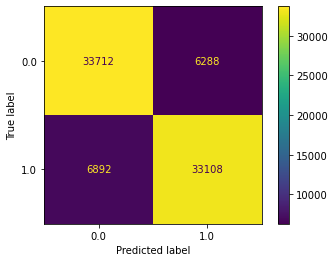

In [39]:
print_metrics(preds, y_test, pipe1)

### feature importance

<AxesSubplot:>

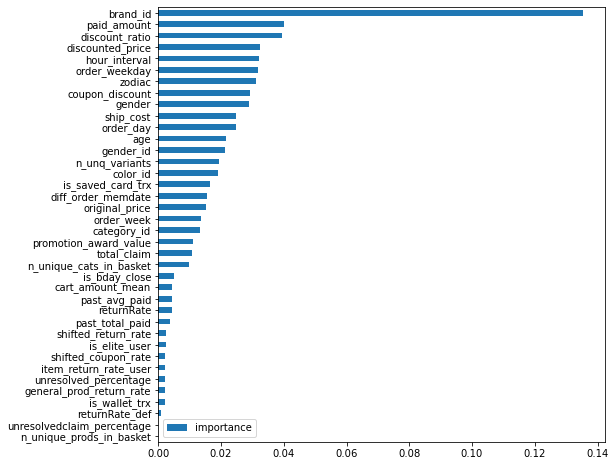

In [100]:
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, pipe1['classifier'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(by='importance').plot(kind='barh',figsize=(8,8))

In [ ]:
auto ml

In [ ]:
grid search

In [ ]:
different encodings
    category_name'i encoding? one-hot
    
    encodings:
    
    Frequency Encoding

    Replace the values with its frequency
    But be careful, some values may have same frequency
    data[‘country’].value_counts()

    Target Encoding (Mean encoding)

    Each of the categories is the variable is replaced with the mean target value for that category
    for each catergory in a column: sum of target / count of target 

## validation

In [40]:
data_path = r'C:\Users\IsmailKaraman\workspace\data\trendyol\\'
test_raw = pd.read_csv(data_path+'test_data.csv')
test_raw.head(2)

,id,expected
0,18115|87073974|726348863,NaN
1,27588|118753298|723169934,NaN


In [41]:
test = test_raw.copy()
test[['user_id', 'product_content_id', 'order_parent_id']] = test['id'].str.split('|',expand=True)
test = test[['user_id', 'product_content_id', 'order_parent_id','expected']]

In [42]:
test.head(3)

,user_id,product_content_id,order_parent_id,expected
0,18115,87073974,726348863,NaN
1,27588,118753298,723169934,NaN
2,29165,35699988,724122443,NaN


In [43]:
null_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405282 entries, 11 to 11193586
Data columns (total 62 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   order_date                  405282 non-null  datetime64[ns, UTC]
 1   user_id                     405282 non-null  int64              
 2   is_elite_user               405282 non-null  int32              
 3   supplier_id                 405282 non-null  int64              
 4   order_line_item_id          405282 non-null  int64              
 5   order_parent_id             405282 non-null  int64              
 6   product_variant_id          405282 non-null  int64              
 7   original_price              405282 non-null  float32            
 8   discounted_price            405282 non-null  float32            
 9   ship_cost                   405282 non-null  float32            
 10  coupon_id                   34784 non-nul

In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7471 entries, 0 to 7470
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             7471 non-null   object 
 1   product_content_id  7471 non-null   object 
 2   order_parent_id     7471 non-null   object 
 3   expected            0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 233.6+ KB


In [45]:
test['user_id'] = test['user_id'].astype('int64') 
test['order_parent_id'] = test['order_parent_id'].astype('int64')
test['product_content_id'] = test['product_content_id'].astype('int64')

In [48]:
null_df.shape

(405282, 62)

In [49]:
test_df = pd.merge(test, null_df, on=['user_id', 'product_content_id', 'order_parent_id'], how='left')

In [50]:
test_df.shape

(7471, 63)

In [56]:
test_df.isna().sum()

user_id 0    0
Name: user_id, dtype: int64
product_content_id 0    0
Name: product_content_id, dtype: int64
order_parent_id 0    0
Name: order_parent_id, dtype: int64
expected 0    7471
Name: expected, dtype: int64
order_date 0    0
Name: order_date, dtype: int64
is_elite_user 0    0
Name: is_elite_user, dtype: int64
supplier_id 0    0
Name: supplier_id, dtype: int64
order_line_item_id 0    0
Name: order_line_item_id, dtype: int64
product_variant_id 0    0
Name: product_variant_id, dtype: int64
original_price 0    0
Name: original_price, dtype: int64
discounted_price 0    0
Name: discounted_price, dtype: int64
ship_cost 0    0
Name: ship_cost, dtype: int64
coupon_id 0    6872
Name: coupon_id, dtype: int64
coupon_discount 0    0
Name: coupon_discount, dtype: int64
promotion_name 0    2601
Name: promotion_name, dtype: int64
promotion_award_value 0    0
Name: promotion_award_value, dtype: int64
is_wallet_trx 0    0
Name: is_wallet_trx, dtype: int64
is_saved_card_trx 0    0
Name: is_saved_

In [ ]:
merged_df.columns

In [57]:
test_X = test_df[categorical_str+categorical_int+numerical+numerical2+passthrough]

In [58]:
test_X.isna().sum()

is_saved_card_trx                0
gender                           0
zodiac                           0
gender_id                        0
category_id                      0
color_id                         0
order_weekday                    0
order_week                       0
brand_id                         0
order_day                        0
hour_interval                    0
n_unq_variants                   0
original_price                   0
discounted_price                 0
ship_cost                        0
coupon_discount                  0
age                              0
diff_order_memdate               0
total_claim                      0
promotion_award_value            0
discount_ratio                   0
paid_amount                      0
n_unique_prods_in_basket         0
n_unique_cats_in_basket          0
cart_amount_mean                 0
past_avg_paid                    0
past_total_paid                  0
returnRate                       0
returnRate_def      

In [60]:
expected = pipe1.predict(test_df[categorical_str+categorical_int+numerical+numerical2+passthrough])

In [65]:
test_raw['expected'] = expected

In [69]:
test_raw['expected'] = test_raw['expected'].astype('int32')

In [70]:
test_raw.to_csv('output.csv', index=False)